Léo Paggen and Alexandru Bălan Temocico

If you want to directly see an approximation of conditional coverage skip the marginal conformal prediction part.


- for both methods we used Studentized residuals to account for the variance from the intervals prediction hardness and to demonstrate the idea as well.

**DOWNLOADING DATASET AND SHORT DESCPRITION OF FEATURES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target

data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We download the california housing data already available in python (it is similar with the Boston dataset from R). First we look at our features and we set the **dependent variable ** to be the median price of the house - this is represented in the last collumn so this will be the variable we try to predict based on the rest of the features.

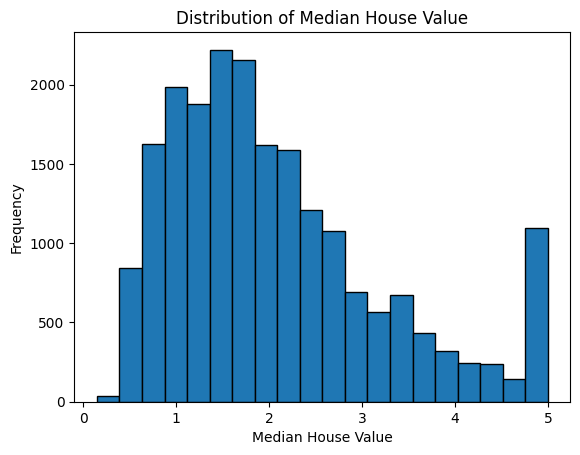

In [ ]:
plt.hist(data['MedHouseVal'], bins=20, edgecolor='black')
plt.xlabel('Median House Values')
plt.ylabel('Frequency')
plt.title('Distribution of Median House Value')
plt.show()

We plotted the distribution of the median prices (has a long-ish tail) but one thing to clarify before starting is that the target variable is represented in hundreds of thousands of dollars ($100,000).

Also we see that high frequency on 5 because when data was collected was used a treshhold so everyhouse with a value of more than 5 * 100,000 was just represented by 5 .

 We picked this dataset as it is also guarantted to have non missing values, it is assumed to be exchangable (but we will demonstrate that still).  

**DEMONSTRATING DATA EXCHANGABILITY**





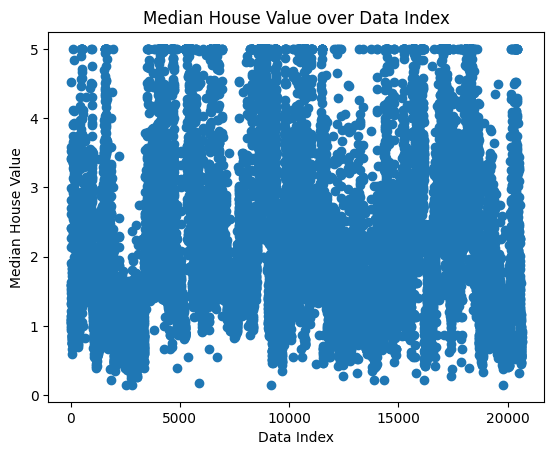

In [ ]:
plt.scatter(range(len(data)), data['MedHouseVal'])
plt.xlabel('Data Index')
plt.ylabel('Median House Value')
plt.title('Median House Value over Data Index')
plt.show()

We see the Median House Prices for each index and we see no relationships or trends. Why we would care?

- Because the main assumption for conformal prediction is exchangable data so we should expect no time dependencies/order dependecy so index should not matter. Basically if we would permute the data the distribution should be the same as there is no indexes dependence.

- To show this we will also randomly shuffle the data into 2 train and test sets (sklearn split does shuffle automatically). WE WOULD EXPECT THE SAME DATA DISTRIBUTIONS FOR BOTH SETS if exchangable because we know from theory distribution should not change after permuting.

- We will just make the train split a bit bigger so we can see the differences in frequency but also see that the distribution is the same in both samples.

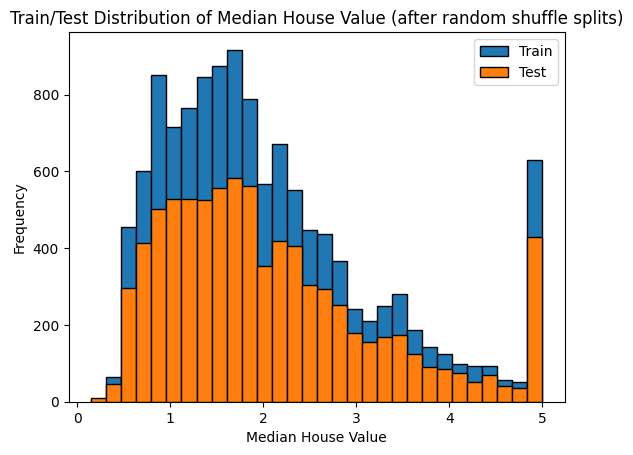

In [ ]:
from sklearn.model_selection import train_test_split

#we make sure to first copy the intiial data
data_copied = data.copy()
train, test = train_test_split(data_copied, test_size=0.4, random_state=42)


plt.hist(train['MedHouseVal'], bins=30, label='Train', edgecolor='black')
plt.hist(test['MedHouseVal'], bins=30, label='Test', edgecolor='black')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Train/Test Distribution of Median House Value (after random shuffle splits)')
plt.show()

**Studentized residuals MARGINAL CONFORMAL PREDICTION**

Now we see the distributions between the 2 samples are shuffle have the same distribution as the initial data and also the same distribution between themselves so we can conclude that our data is exchangable.

In [ ]:
#now we split into TRAIN, CALIBRATION and TEST the data.
#we will keep 70% for training and the rest 30% we will split in 20 for calibration and 10% for testing
D1, temp_data = train_test_split(data, test_size=0.30, random_state=42)

# test should be 10% from the 30% left so (10/30) which is around 33.33
D2, D3 = train_test_split(temp_data, test_size=0.33333, random_state=42)


#to make sure the sizes are correct
print(D1.shape)
print(D2.shape)
print(D3.shape)


(14448, 9)
(4128, 9)
(2064, 9)


Because we want to keep some sort of adaptablity in our intervals we will use the Studentized residuals method which basically also fits a "spread predictor" to account for the standard deviations of our model predictions at X= x.

The studentized residual should adapt to the local hardness of prediction.
We will compare this with the classic split method of just using the abosulute residuals.

In [ ]:
from sklearn.ensemble import RandomForestRegressor


features = california.feature_names
target = 'MedHouseVal'

#we fit a linear model regression to keep it simple on D1 data
#model_f = LinearRegression()
#model_f.fit(D1[features], D1[target])

model_f = RandomForestRegressor(n_estimators=10, random_state=42)
model_f.fit(D1[features], D1[target])

#we will compute the SD for each point from D1 to see how much variance is in our
#predictions so we can adapt our intervals based on this
#this is called the Studentized residuals

D1['abs_residual'] = np.abs(D1[target] - model_f.predict(D1[features]))

# We then fit another linear regression model on D1 to predict these absolute residuals.
# This model approximates the variance our predictions.
#model_sigma = LinearRegression()
#model_sigma.fit(D1[features], D1['abs_residual'])


model_sigma = RandomForestRegressor(n_estimators=10, random_state=42)
model_sigma.fit(D1[features], D1['abs_residual'])

RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
#now we just use our both predictors trained on train set D1 to the calibration
#set to get the residuals. We should take care to normalize the residuals by the
#sigma term so we account for the hardness of the prediction
f_pred = model_f.predict(D2[features])

sigma_pred = model_sigma.predict(D2[features])

abs_residuals_calib = np.abs(D2[target] - f_pred)

studentized_residuals_calib = abs_residuals_calib / sigma_pred

alpha = 0.1  # for a 90% prediction interval
sorted_studentized = np.sort(studentized_residuals_calib)
n2 = len(sorted_studentized)
k = int(np.ceil((n2 + 1) * (1 - alpha))) - 1
q_hat_studentized = sorted_studentized[k]

print("Quantile for studentized absolute residuals:", q_hat_studentized)

#now we do the same but for the absolute error we didnt need to divide anymore
#by the predicted sd so we direclty sort the abs_residuals
sorted_abs = np.sort(abs_residuals_calib)
k_abs = int(np.ceil((n2 + 1) * (1 - alpha))) - 1
q_hat_abs = sorted_abs[k_abs]


Quantile for studentized absolute residuals: 6.346374603089357


Now the next step is just to generate predicitons on the test set D3 with the both estimators that we have and construct the intervals (studentized ones so we need to multiply with our sigma term)

In [ ]:
#we predict with our trianed estimators
f_pred_test = model_f.predict(D3[features])
sigma_pred_test = model_sigma.predict(D3[features])

# For each test instance, the interval is [predicted value - q_hat * predicted sigma, predicted value + q_hat * predicted sigma]
lower_bounds_test = f_pred_test - q_hat_studentized * sigma_pred_test
upper_bounds_test = f_pred_test + q_hat_studentized * sigma_pred_test

#wider when the model predicts higher uncertainty

# For each test instance, the interval is [predicted value - q_hat , predicted value + q_hat] for normal split method without using the predicted sd
lower_bounds_test_abs = f_pred_test - q_hat_abs
upper_bounds_test_abs = f_pred_test + q_hat_abs

#we're're adding and subtracting the same constant for every test instance
#regardless of how much uncertainty is for each prediction the intervals are equal.


#print (lower_bounds_test)
#print (upper_bounds_test)


**Absolute Error Residuals VS Studentized residuals**

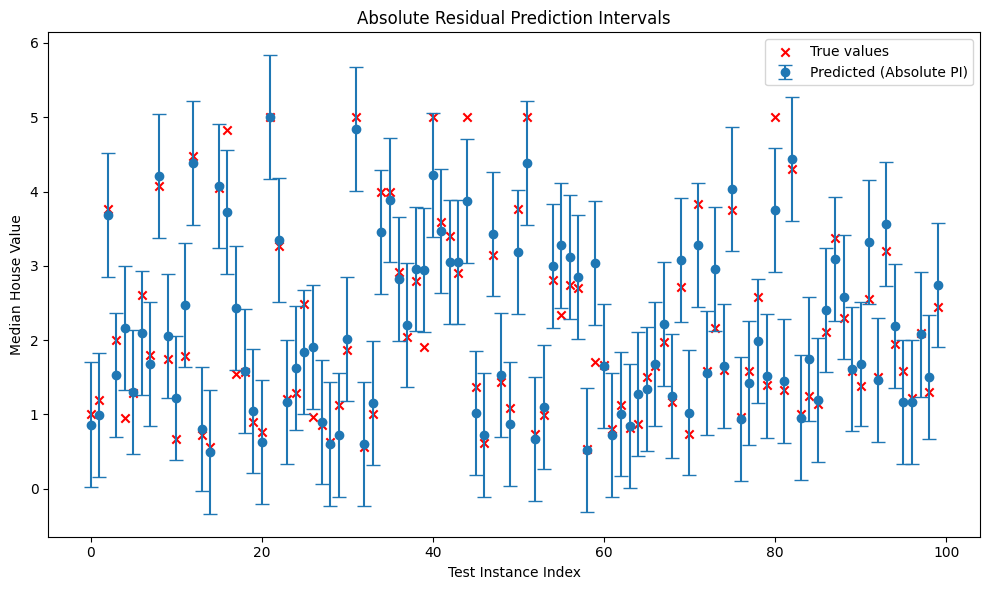

In [ ]:
import matplotlib.pyplot as plt

sample = 100
sample_indices = np.arange(sample)

plt.figure(figsize=(10, 6))

#for absolute residual intervals, the quantile is always constant
error_sampled_abs = np.full(sample, q_hat_abs)

plt.errorbar(np.arange(sample), f_pred_test[sample_indices],
             yerr=error_sampled_abs, fmt='o', capsize=5,
             label='Predicted (Absolute PI)')
plt.scatter(np.arange(sample), D3[target].values[sample_indices],
            color='red', label='True values', marker='x')
plt.xlabel('Test Instance Index')
plt.ylabel('Median House Value')
plt.title('Absolute Residual Prediction Intervals')
plt.legend()
plt.tight_layout()
plt.show()


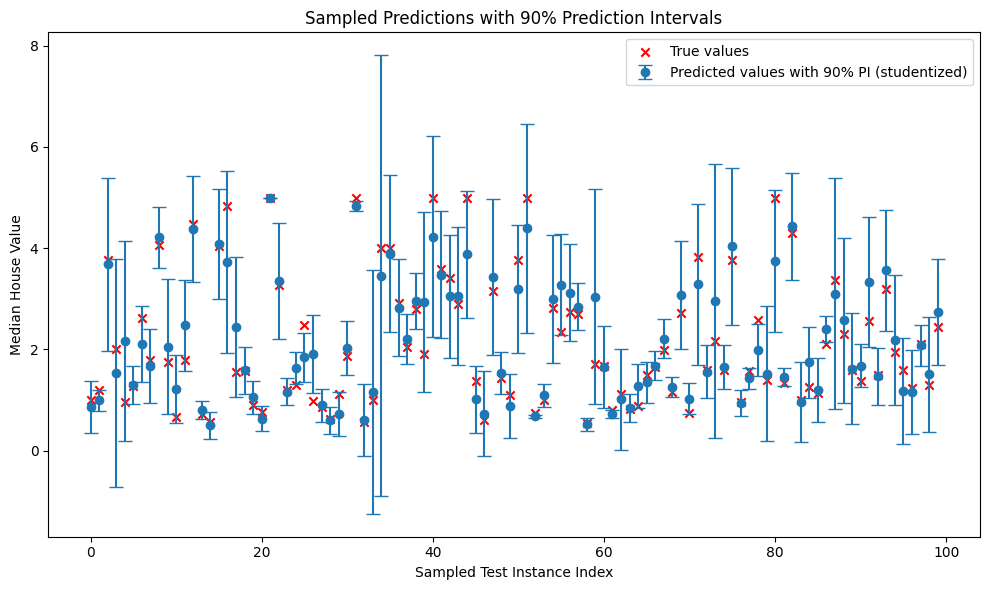

In [ ]:
import matplotlib.pyplot as plt

#we will just take a sample of 100 points because otherwise the plot is too crowded

sample = 100
sample_indices = np.arange(sample)

plt.figure(figsize=(10, 6))
error_sampled = q_hat_studentized * np.abs(sigma_pred_test[sample_indices])

# we plot the predicted values from the sample and also the error
plt.errorbar(np.arange(sample), f_pred_test[sample_indices], yerr=error_sampled, fmt='o', capsize=5, label='Predicted values with 90% PI (studentized)')


plt.scatter(np.arange(sample), D3[target].values[sample_indices], color='red', label='True values', marker='x')
plt.xlabel('Sampled Test Instance Index')
plt.ylabel('Median House Value')
plt.title('Sampled Predictions with 90% Prediction Intervals')
plt.legend()
plt.tight_layout()
plt.show()

Now we see our intervals and thatin general the predicted values are close to the true ones. Mostly because we used a random forest instea dof linear regression. Now let's see that the theorem of conformal predcition actually hols in practice.

- we should include in our intervals at least 90% of the true values. We now check this

In [ ]:
#the true value should be between our interval end points, easy
covered = (D3[target].values >= lower_bounds_test) & (D3[target].values <= upper_bounds_test)


coverage_rate = np.mean(covered)
print("Coverage rate is: " + str(coverage_rate*100))

#this is almost 90% but we assume is happening due to the limited sample size we are using.
#we might want to increase our calbiration set to make sure we converge to 90% guarantee


Coverage rate is: 89.82558139534885


**CONDITIONAL COVERAGE (approximation)**

With the marginal conformal prediction we have no guarantee that for every given value of the predictors the interval will have 90% coverage. Some subgroups might have slightly higher or lower coverage.


Conditional coverage means that for almost every fixed value or subgroup of X we cover at least 90% from the true targets  - I said almost because we know we cant achieve exact conditional coverage

Achieving exact conditional coverage is not possible and was demonstrated in 2014.

For this reason, to still demonstrate the conditional coverage we will condition on different subgroups of a feature (AveRooms in this case) and see if we can still guarantee the 90% coverage.

- we will group the average numbers of rooms into 3 different bins and condition on those. Indeed this is not full conditional coverage but it is still demonstrating the concept by conditioning on subgroups.


<ipython-input-112-320a1e7a9ad4>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_by_bin = D3.groupby('AveRooms_bin')['covered'].mean()
<ipython-input-112-320a1e7a9ad4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coverage_by_bin.index, y=coverage_by_bin.values, palette="Blues_d", edgecolor='black')


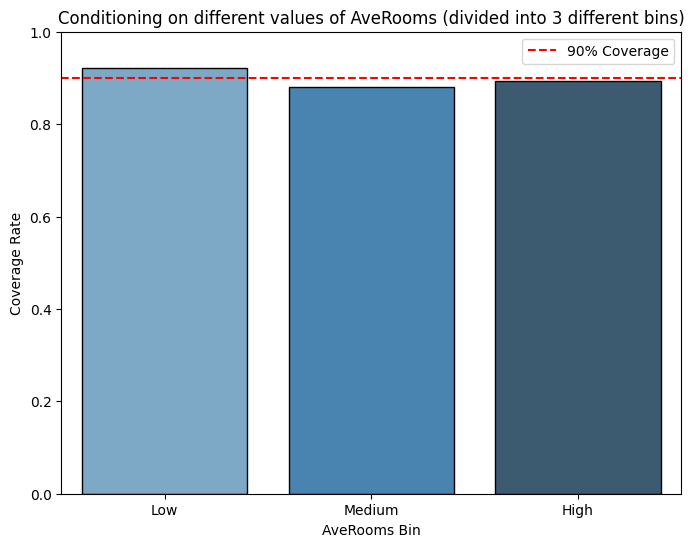

In [ ]:
D3 = D3.copy()

D3['prediction'] = f_pred_test
D3['lower'] = lower_bounds_test
D3['upper'] = upper_bounds_test

D3['covered'] = (D3[target] >= D3['lower']) & (D3[target] <= D3['upper'])
D3['AveRooms_bin'] = pd.qcut(D3['AveRooms'], q=3, labels=['Low', 'Medium', 'High'])


coverage_by_bin = D3.groupby('AveRooms_bin')['covered'].mean()


plt.figure(figsize=(8, 6))
sns.barplot(x=coverage_by_bin.index, y=coverage_by_bin.values, palette="Blues_d", edgecolor='black')
plt.xlabel('AveRooms Bin')
plt.ylabel('Coverage Rate')
plt.ylim(0, 1)
plt.title('Conditioning on different values of AveRooms (divided into 3 different bins)')
plt.axhline(0.9, color='red', linestyle='--', label='90% Coverage')
plt.legend()
plt.show()

We see some small deviations from the at least 90% coverage especially in the medium bin. As the deviation is still small this is normal, but however it might suggest that the conformal intervals might not be well calibrated for some specific values of the feature.

- marginal coverage is obtained by conditional coverage is very challenging even as an approximation for different subgroups instead of for every X=x.

We will show one more example by conditioning on a different feature this time. We use the population feature and we will split it in 5 different beans increasing order by their quantiles. We should expect to get coverage of at least 90% FOR EACH bin.

<ipython-input-113-e7a9fcb55962>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_by_population = D3.groupby('Population_bin_q')['covered'].mean()
<ipython-input-113-e7a9fcb55962>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coverage_by_population.index.astype(str), y=coverage_by_population.values,


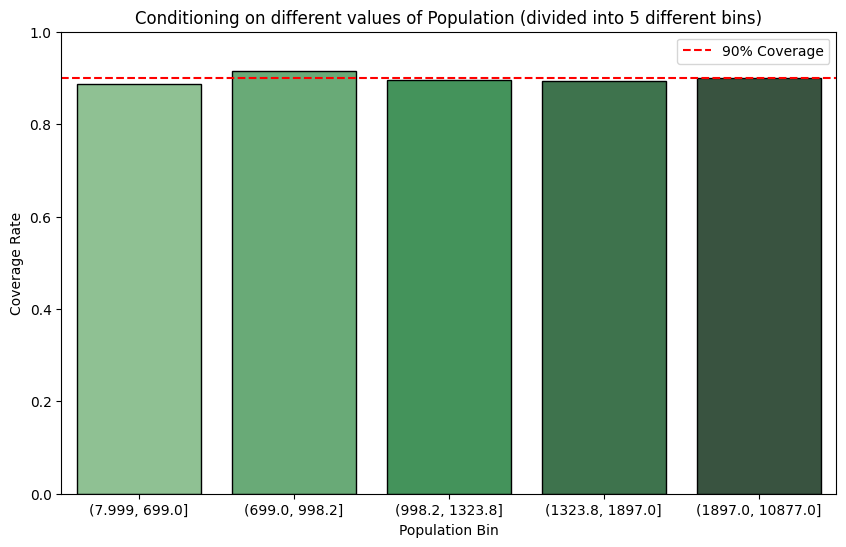

In [ ]:
D3['Population_bin_q'] = pd.qcut(D3['Population'], q=5)
#print(D3['Population_bin_q'].value_counts().sort_index())

#we just made sure we have aproxximately equal number of entires for each bin

coverage_by_population = D3.groupby('Population_bin_q')['covered'].mean()
#print("Coverage rate by Population quantile bin:")
#print(coverage_by_population)


plt.figure(figsize=(10, 6))
sns.barplot(x=coverage_by_population.index.astype(str), y=coverage_by_population.values,
            palette="Greens_d", edgecolor='black')
plt.xlabel('Population Bin')
plt.ylabel('Coverage Rate')
plt.ylim(0, 1)
plt.title('Conditioning on different values of Population (divided into 5 different bins)')
plt.axhline(0.9, color='red', linestyle='--', label='90% Coverage')
plt.legend()
plt.show()

Now we conditioned on another feature as well and subdivided the values into 5 different bins to approximate conditional coverage. Again, **this will be just an aproximation to demonstrate the concept**, as exact conditional coverage is impossible to obtain. Now we see that we get very close to the 90% coverage rate for all the bins. The first bin is still a bit under the trehshold of 90% which again means our conformal intervals might not the best for those specific values of the feature X.


- we see that we are very close in approximating conditional coverage for subgroups but we might still see some subgroups which not have a guaranted coverage of 90%. In general, more data for the calibration test should solve those small deviations that we obtain now. But for this limited size dataset would result in not enough train data.
